In [1]:
from matplotlib import pyplot as plt
import numpy as np
from typing import Callable

newparams = {'figure.figsize': (12, 6), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}

plt.rcParams.update(newparams)

In [2]:

# Funksjon som løser en 4 dimensjonal diffrensialligning ved hjelp av Runge-Kutta sin metode av 4. orden. returnerer en liste
# med y verdier og en liste med tidspunkt
# Parametre:
# F: funksjon som tar inn en liste med y verdier og en liste som y' skal lagres i
# y0: initialverdier til problemet
# h: lengden på tidssteg
# t0: starttidspunkt
# t1: slutttidspunkt
def Runge_Kutta4(F, y0, h, t0, t1):
    # Oppretter en liste med nødvendige verdier for tidspunkt
    N = int((t1-t0)/h)+1
    if (t0+h*N != t1):
        t_list = np.array([t0 + h*i for i in range(N)] + [t1])
        N+=1
    else:
        t_list = np.array([t0 + h*i for i in range(N)])
    
    # Oppretter en matrise for å lagre midlertidige verdier
    F_vec = np.zeros((4, 4))
    
    # Oppretter en matrise for å lagre y verdier
    y_list = np.zeros((N, 4))
    y_list[0] = y0
    
    # Løkke for å lagre y verdier for alle tidsstegene
    for n in range(N-1):
        # Endrer tidssteg dersom man er på siste skritt
        if(n == N-2):
            h = t_list[-1] - t_list[-2]
        
        # Regner ut neste y verdi, og lagrer denne
        F(y_list[n], F_vec[:,0])
        F(y_list[n] + 0.5*h*F_vec[:,0], F_vec[:,1])
        F(y_list[n] + 0.5*h*F_vec[:,1], F_vec[:,2])
        F(y_list[n] + h*F_vec[:,2], F_vec[:,3])
        
        y_list[n+1] = y_list[n] + h*(1/6 * F_vec[:,0] + 1/3*F_vec[:,1] + 1/3 * F_vec[:,2]+1/6*F_vec[:,3])
        
    return y_list, t_list

# Funksjon som løser en 4 dimensjonal diffrensialligning ved hjelp av Runge-Kutta sin metode av 4. orden. returnerer en liste
# med y verdier
# Parametre:
# F: funksjon som tar inn en liste med y verdier og en liste som y' skal lagres i
# y0: initialverdier til problemet, liste med 4 verdier
# h: lengden på tidssteg
def Runge_Kutta4_new_version(F: Callable[[np.ndarray, np.ndarray], np.void], y0: np.ndarray, h: float, stop_function: Callable[[np.ndarray], bool]) -> np.ndarray:
    # Oppretter en matrise for å lagre midlertidige verdier
    F_vec: np.ndarray = np.zeros((4, 4))
    
    # Oppretter en matrise for å lagre y verdier
    y_list = [y0]
    
    # Løkke for å lagre y verdier for alle tidsstegene
    while not stop_function(y_list[-1]):
        # Regner ut neste y verdi, og lagrer denne
        F(y_list[-1], F_vec[:,0])
        F(y_list[-1] + 0.5*h*F_vec[:,0], F_vec[:,1])
        F(y_list[-1] + 0.5*h*F_vec[:,1], F_vec[:,2])
        F(y_list[-1] + h*F_vec[:,2], F_vec[:,3])
        
        y_next: np.ndarray = y_list[-1] + h*(1/6 * F_vec[:,0] + 1/3*F_vec[:,1] + 1/3 * F_vec[:,2]+1/6*F_vec[:,3])
        y_list.append(y_next)
    return np.array(y_list)


def xl_function(y_list):
    r = -y_list[-2, 2]/y_list[-1, 2]
    return 1/(r+1) * (y_list[-2, 0] + r*y_list[-1, 0])

def get_range(theta_list, v0, F_function, h, length_function = xl_function):
    range_list = []
    for theta in theta_list:
        y0 = np.array([0, v0*np.cos(theta), 0, v0*np.sin(theta)])
        y_list = Runge_Kutta4(F_function, y0, h)
        range_list.append(length_function(y_list))
    range_list = np.array(range_list)
    
    return range_list

In [3]:
def F_trebuchet_equations_of_motion(y_list: np.ndarray, dy_list: np.ndarray, A_matrix: np.ndarray, b_vector: np.ndarray) -> np.void:
    dy_list[0] = y_list[1]                                                      # d(theta)/dt
    dy_list[1] = np.linalg.inv(A_matrix).dot(b_vector)[0]     # d^2(theta)/dt^2
    dy_list[2] = y_list[3]                                                     # d(psi)/dt
    dy_list[3] = np.linalg.inv(A_matrix).dot(b_vector)[1]     # d^2(psi)/dt^2

def F_function_no_drag(y_list: np.ndarray, dy_list: np.ndarray, g: float = 9.81) -> np.void:
    dy_list[0] = y_list[1]  # dx/dt
    dy_list[1] = 0          # d(vx)/dt
    dy_list[2] = y_list[3]  # dy/dt   
    dy_list[3] = -g         # d(vy)/dt

In [4]:
def a11_function(psi: float, l1: float, m1: float, l2: float, m2: float, l4: float) -> float:
    return -l1**2 * m1 - l2**2 * m2 + 2*l2*l4*m2*np.cos(psi) - l4**2 * m2

def a12_function(psi: float, l4: float, m2: float, l2: float) -> float:
    return -l4*m2*(l2*np.cos(psi)-l4)

def a22_function(l4: float, m2: float) -> float:
    return -l4**2 * m2

def A_function(psi: float, a11_function: Callable[[float], float], a12_function: Callable[[float], float], a22_function: Callable[[float], float]) -> np.ndarray:
    return np.array([
        [a11_function(psi), a12_function(psi)],
        [a12_function(psi), a22_function(psi)]
        ])


def b1_function(theta: float, dtheta: float, psi: float, dpsi: float, m1: float, l1: float, m2: float, l2: float, l4: float, g: float) -> float:
    return g*m1*l1*np.sin(theta) - g*m2*(l2*np.sin(theta) + l4*np.sin(psi-theta)) - l2*l4*m2*(dpsi - 2*dtheta)*np.sin(psi)*dpsi

def b2_function(theta: float, psi: float, dtheta: float, l4: float, m2: float, l2: float, g: float) -> float:
    return l4*m2*(g*np.sin(psi-theta) - l2*np.sin(psi)*dtheta**2)

def b_function(theta: float, dtheta: float, psi: float, dpsi: float, b1_function: Callable[[float, float, float, float], float], b2_function: Callable[[float, float, float], float]) -> np.ndarray:
    return np.array([b1_function(theta, dtheta, psi, dpsi), b2_function(theta, psi, dtheta)])

def r2b_function(theta: float, psi: float, l2: float, l3: float, l4: float) -> np.ndarray:
    return np.array([
            -l2*np.sin(theta) - l4*np.sin(psi-theta),
            l2*np.cos(theta) + l3 - l4*np.cos(psi-theta)
        ])

def v2b_function(theta: float, dtheta: float, psi: float, dpsi: float, l2: float, l4: float) -> np.ndarray:
    return np.array([
            -l2*np.cos(theta)*dtheta - l4*np.cos(psi-theta)*(dpsi - dtheta),
            -l2*np.sin(theta)*dtheta + (dpsi - dtheta)*l4*np.sin(psi-theta)
        ])

In [5]:
# defining initial conditions:
m1: float = 2000
m2: float = 15
l1: float = 1.2
l2: float = 5.7
l3: float = 3.2
l4: float = 5
g: float = 9.81
theta0: float = 0.7*np.pi
dtheta0: float = 0
psi0: float = theta0 - 0.5*np.pi
dpsi0: float = 0
y0_trebuchet: np.ndarray = np.array([theta0, dtheta0, psi0, dpsi0])

In [6]:
# defining functions with params
a11_lambda: Callable[[float], float] = lambda psi : a11_function(psi, l1, m1, l2, m2, l4)
a12_lambda: Callable[[float], float] = lambda psi : a12_function(psi, l4, m2, l2)
a22_lambda: Callable[[float], float] = lambda psi : a22_function(l4, m2)

b1_lambda: Callable[[float, float, float, float], float] = lambda theta, dtheta, psi, dpsi : b1_function(theta, dtheta, psi, dpsi, m1, l1, m2, l2, l4, g)
b2_lambda: Callable[[float, float, float], float] = lambda theta, psi, dtheta : b2_function(theta, psi, dtheta, l4, m2, l2, g)

A_lambda: Callable[[float], np.ndarray] = lambda psi : A_function(psi, a11_lambda, a12_lambda, a22_lambda)
b_lambda: Callable[[float, float, float, float], np.ndarray] = lambda theta, dtheta, psi, dpsi : b_function(theta, dtheta, psi, dpsi, b1_lambda, b2_lambda)

F_lambda_treb: Callable[[np.ndarray, np.ndarray], np.void] = lambda y_list, dy_list : F_trebuchet_equations_of_motion(y_list, dy_list, A_lambda(y_list[2]), b_lambda(y_list[0], y_list[1], y_list[2], y_list[3]))

## Task 2

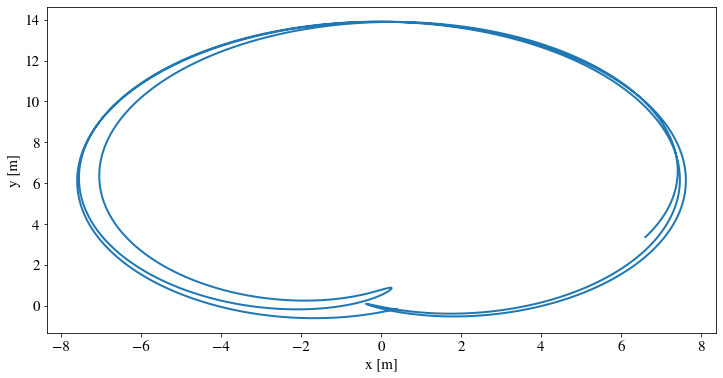

In [7]:
h: float = 0.001
t_end = 5
y_list, t_list = Runge_Kutta4(F_lambda_treb, y0_trebuchet, h, 0, t_end)
positions: np.ndarray = r2b_function(y_list[:, 0], y_list[:, 2], l2, l3, l4)
plt.plot(positions[0, :], positions[1, :])
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

The figure above is a plot of the positions of the projectile for the first 5 seconds. It appears that the motion is approximately periodic. It also appears like the projectile is alternating between swinging clockwise and counterclockwise. This happens due to the counterweight acting as a pendulum.

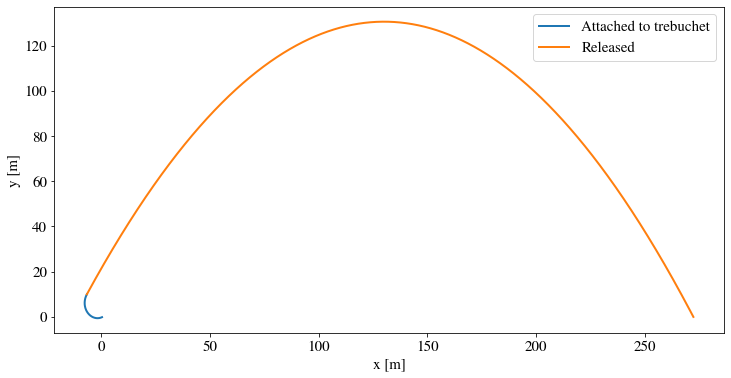

In [8]:
h: float = 0.001
y_list: np.ndarray = Runge_Kutta4_new_version(F_lambda_treb, y0_trebuchet, h, lambda y : y[0] < 0.1*np.pi)
positions: np.ndarray = r2b_function(y_list[:, 0], y_list[:, 2], l2, l3, l4)
velocities: np.ndarray = v2b_function(y_list[:, 0], y_list[:, 1], y_list[:, 2], y_list[:, 3], l2, l4)
init_vals: np.ndarray = np.array([positions[0, -1], velocities[0, -1], positions[1, -1], velocities[1, -1]])

y_list_thrown: np.ndarray = Runge_Kutta4_new_version(F_function_no_drag, init_vals, h, lambda y : y[2] < 0)

plt.plot(positions[0, :], positions[1, :], label="Attached to trebuchet")
plt.plot(y_list_thrown[:,0], y_list_thrown[:,2], label="Released")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend()
plt.show()

The plot above shows the path of the projectile with a release angle of $\theta_r = 0.1\pi$ radians. 

In [9]:
h: float = 0.001
thetar_list = np.linspace(0, 40*np.pi/180, 100)
lengths = []
for thetar in thetar_list:
    y_list: np.ndarray = Runge_Kutta4_new_version(F_lambda_treb, y0_trebuchet, h, lambda y : y[0] < thetar)
    positions: np.ndarray = r2b_function(y_list[:, 0], y_list[:, 2], l2, l3, l4)
    velocities: np.ndarray = v2b_function(y_list[:, 0], y_list[:, 1], y_list[:, 2], y_list[:, 3], l2, l4)
    init_vals: np.ndarray = np.array([positions[0, -1], velocities[0, -1], positions[1, -1], velocities[1, -1]])

    y_list_thrown: np.ndarray = Runge_Kutta4_new_version(F_function_no_drag, init_vals, h, lambda y : y[2] < 0)

    # plt.plot(positions[0, :], positions[1, :])
    # plt.plot(y_list_thrown[:,0], y_list_thrown[:,2], label=r"$\theta_r=$" + f"{thetar*180/np.pi:.1f}" + r"$\degree$")
    lengths.append(y_list_thrown[-1, 0])


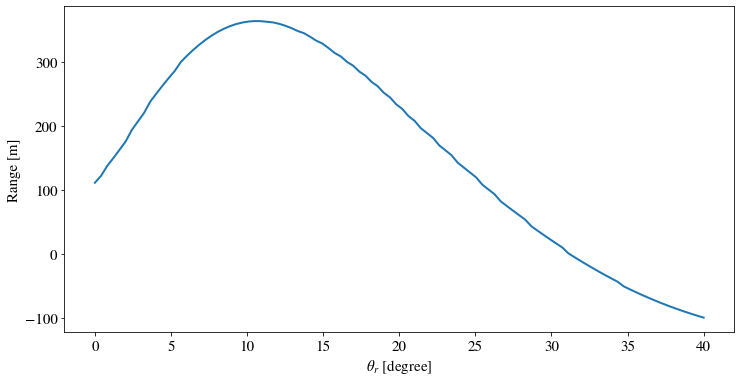

In [125]:
plt.plot(thetar_list*180/np.pi, lengths)
plt.xlabel(r"$\theta_r$ [degree]")
plt.ylabel("Range [m]")
plt.show()

The plot above shows the length the projectile was able to fly plotted against the release angle of the projectile. Notice that the direction of the projectile changes direction around when $\theta_r = 30\degree$.  